# How to use the Chemistry Solver

In this tutorial, you can use the chemistry algorithm of pyC$^2$Ray as stand alone. However, this tutorial uses a simplified version of the full chemistry solver (_doric_ method), without convergence loop for large time-step. 


Therefore, we suggest the user to __employ the chemistry solver__ as a __stand alone only for very small time-step__ ($\Delta t < 100\,\rm yr$). Otherwise, convergence to the analytical solution is not granted.

## Reionization Chemistry Equation for Hydrogen

Solving the hydrogen ionization fraction is not entirely trivial since this corresponds to a _stiff partial differential equation_. The evolution of ionized hydrogen can be written as:

$$ \frac{dx_\mathrm{HII}}{dt} = (1-x_\mathrm{HII})\Gamma_\mathrm{HI} - x_\mathrm{HII}\, n_\mathrm{e} \alpha_\mathrm{HI}$$

The variables in this equation are:

- $n_\mathrm{e}$ : the electron number density (itself depends on $x_\mathrm{HII}$).
- $\alpha_\mathrm{HI}$ : the recombination coefficients for hydrogen (depends on the gas temperature). In our case, we assume the On-The-Spot (OTS) approximation, i.e. recombination to the ground state is locally absorbed). This approximation is equivalent to the Case B recombination coefficient.
- $\Gamma_\mathrm{HI}$ : the photoionization rate for neutral hydrogen (itself depends on $x_\mathrm{HI}$).

We can find an analytical solution if we assume $n_\mathrm{e}$, $\alpha_\mathrm{HI}$ and $\Gamma_\mathrm{HI}$ to be constant. For an inital condition $x_\mathrm{HII,0}$, the solution is:

$$x_\mathrm{HII}(t) = x_\mathrm{eq}+\left(x_\mathrm{HII,0} + x_\mathrm{eq} \right)\,e^{t/t_\mathrm{i}}$$

With a time parameter:

$$ t_\mathrm{i} = \frac{1}{\Gamma_\mathrm{HI} + n_\mathrm{e} \alpha_\mathrm{HI}} $$ 

The equilibrium solution:

$$ x_\mathrm{eq} = \frac{\Gamma_\mathrm{HI}}{\Gamma_\mathrm{HI} + n_\mathrm{e} \alpha_\mathrm{HI}} $$ 

Using this solution and iterating for the electron density, we can derive an analytical solution for the _time averaged chemistry solution_ (TACS) for a discrete time step $\Delta t$ with solution:

$$ \left< x_\mathrm{HII} \right> = \frac{1}{\Delta t} \int^{t+\Delta t}_{t} x_\mathrm{HII}(t')dt' = x_\mathrm{eq} + \left(x_\mathrm{HII,0} + x_\mathrm{eq} \right) \left(1 - e^{-\Delta t /t_\mathrm{i}} \right) \frac{t_\mathrm{i}}{\Delta t}$$

Below, we show a simple implementation of how to use the chemistry solver.

In [2]:
import numpy as np
import pyc2ray as pc2r
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as cst
from astropy.cosmology import Planck18 as cosmo

from tqdm import tqdm

In this example, we define some random density fields for the gas density `ndens`, temperature `temp`, ionization fraction `xh`, and photo-ionization rate `phi_ion`. These four fields can be a single value or a numpy array with the same shape.

In [3]:
mesh_shape = (10,10,10)

np.random.seed(2023)
# density field [g/cm^3]
ndens = np.random.normal(loc=1e-7, scale=1e-8, size=mesh_shape)

# temperature [K]
temp = np.ones(mesh_shape)*1e4

# Hydrogen ionization fraction
xh = np.random.uniform(low=0, high=0.1, size=mesh_shape)
xh_ini = xh

# photo-ionization rate [s^-1]
phi_ion = np.random.uniform(low=1e-13, high=1e-12, size=mesh_shape)

# clumping factor
clumping = np.ones(mesh_shape)

## Run Time-Averaged Chemistry Solution

Define a time length `dt` (in seconds units) and loop over `t_steps` many time-steps.

The chemistry solver method employed in a pyC$^2$Ray assumes a __constant electron density__ $n_e$ and __photo-ionization rate__ $\Gamma_{\rm HI}$ within each time-step, $\Delta t$ (which can be of several Myr). Moreover, the solution of the 

Therefore, cosmological runs include a convergence loop to update the two fields and converge to the correct solution.

Therefore, if you wish to __use the chemistry solver alone__, you need to select a relatively __small time length__ ($\Delta t<100\, \rm yr$), and this can depend on the strength of the source flux or ionization fraction of the voxel. For this reason, the code fails if more than 1% of the voxels do not converge.

In [4]:
# time-step
dt = 50*u.yr
t_steps = 1000

print('Volume-averaged ionized fraction at t=0: %.3f' %np.mean(xh_ini))

# array to show the time evolution of the solution
mean_xHII = np.zeros(t_steps)

# calculate ODE
for i in tqdm(range(t_steps)):
    new_xh = pc2r.hydrogen.hydrogenODE(dt=dt.cgs.value, ndens=ndens, temp=temp, xh=xh, phi_ion=phi_ion, clump=clumping)
    xh = new_xh
    
    # save value one voxel to show temporal evolution
    mean_xHII[i] = xh[8,5,6]

print('Volume-averaged ionized fraction after t=%d %s: %.3f' %(dt.value*t_steps, dt.unit, np.mean(xh)))

Volume-averaged ionized fraction at t=0: 0.050


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1061.30it/s]

Volume-averaged ionized fraction after t=50000 yr: 0.559


Plot the results the inital and final neutral fraction field.

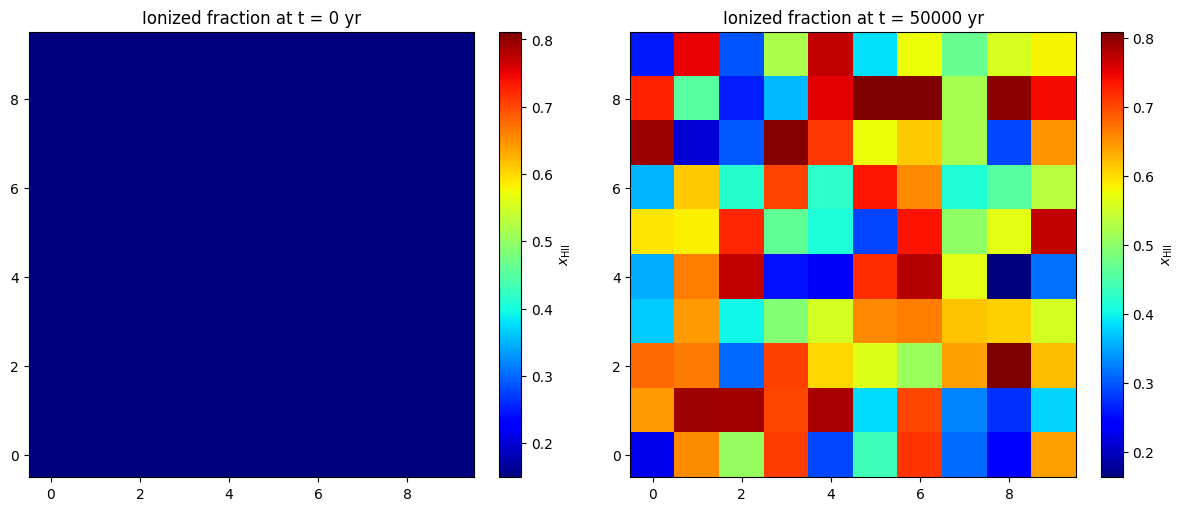

In [5]:
fig, axs = plt.subplots(figsize=(12,5), ncols=2, nrows=1, layout="constrained")
axs[0].set_title('Ionized fraction at t = 0 %s' %dt.unit)
im = axs[0].imshow(xh_ini[:,mesh_shape[1]//2,:], origin='lower', cmap='jet', vmin=xh.min(), vmax=xh.max())
plt.colorbar(im, ax=axs[0], label=r'$x_{\rm HII}$')

axs[1].set_title('Ionized fraction at t = %d %s' %(dt.value*t_steps, dt.unit))
im = axs[1].imshow(xh[:,mesh_shape[1]//2,:], origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[1], label=r'$x_{\rm HII}$')

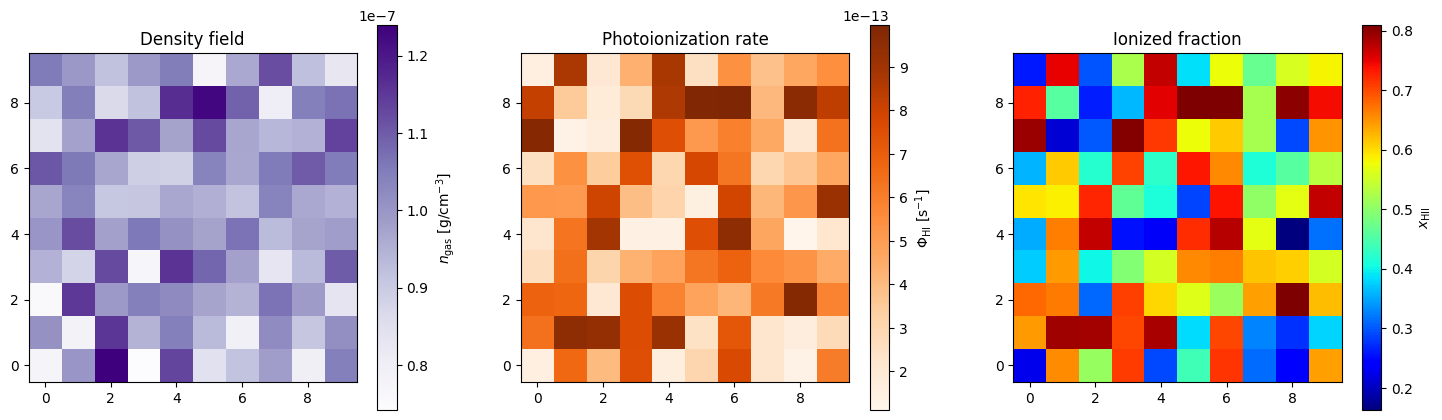

In [6]:
fig, axs = plt.subplots(figsize=(18,5), ncols=3, nrows=1)
axs[0].set_title('Density field')
im = axs[0].imshow(ndens[:,mesh_shape[1]//2,:], origin='lower', cmap='Purples')
plt.colorbar(im, ax=axs[0], label=r'$n_{\rm gas}$ [g/$\rm cm^{-3}$]')

axs[1].set_title('Photoionization rate')
im = axs[1].imshow(phi_ion[:,mesh_shape[1]//2,:], origin='lower', cmap='Oranges')
plt.colorbar(im, ax=axs[1], label=r'$\Phi_{\rm HI}$ [$\rm s^{-1}$]')

axs[2].set_title('Ionized fraction')
im = axs[2].imshow(xh[:,mesh_shape[1]//2,:], origin='lower', cmap='jet')
plt.colorbar(im, ax=axs[2], label=r'$x_{\rm HII}$')

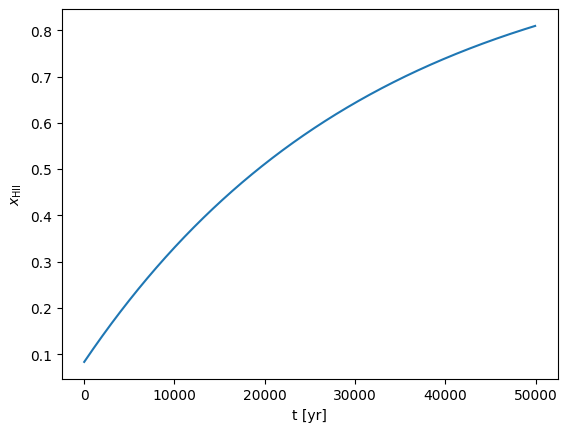

(None, None)

<Figure size 640x480 with 0 Axes>

In [7]:
time_step = np.arange(0, t_steps)*dt
plt.plot(time_step, mean_xHII)
plt.xlabel('t [yr]'), plt.ylabel(r'$x_\mathrm{HII}$')
plt.show(), plt.clf()